# MLP Project T32025 – Cinema Audience Forecasting

**Student:** Kirti Gupta  
**Roll No.:** 21f1000474  

This notebook is my FinalNotebook for the MLP Project T32025 Kaggle competition.

**Goal:**  
Predict the daily **audience_count** for each `book_theater_id` using historical bookings, theatre metadata, and calendar information. This is a **time-series regression** problem.

**High-level approach:**

1. Load and understand all the provided tables.
2. Perform exploratory data analysis (EDA) to study audience patterns.
3. Detect and handle missing values and outliers.
4. Engineer meaningful features:
   - Date-based features (day, month, weekend, etc.)
   - Theatre-level features (location, area frequency)
   - Aggregated booking features (tickets_booked_sum, tickets_sold_sum)
   - Time-series lag features (`lag1`, `lag7`, `lag7_mean`)
5. Build a preprocessing pipeline (imputation, scaling, encoding) using `ColumnTransformer` and `Pipeline`.
6. Train and compare **three models**:
   - Ridge Regression (with hyperparameter tuning)
   - Random Forest
   - LightGBM
7. Select **Random Forest** as the final model for submission based on validation and Kaggle leaderboard score.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


In [2]:
import random, warnings, os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb


from datetime import datetime

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Display options
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 120)

data_dir = "/kaggle/input/Cinema_Audience_Forecasting_challenge"
target_col="audience_count"

print("Setup ready")


Setup ready


## Data Loading 

 

 Target variable: `audience_count` 


In [3]:
# Load csvs
date_info = pd.read_csv(f"{data_dir}/date_info/date_info.csv")
booknow_booking = pd.read_csv(f"{data_dir}/booknow_booking/booknow_booking.csv")
booknow_theaters = pd.read_csv(f"{data_dir}/booknow_theaters/booknow_theaters.csv")
booknow_visits = pd.read_csv(f"{data_dir}/booknow_visits/booknow_visits.csv")
cinePOS_booking = pd.read_csv(f"{data_dir}/cinePOS_booking/cinePOS_booking.csv")
cinePOS_theaters = pd.read_csv(f"{data_dir}/cinePOS_theaters/cinePOS_theaters.csv")
movie_theater_id_relation = pd.read_csv(f"{data_dir}/movie_theater_id_relation/movie_theater_id_relation.csv")
sample_submission = pd.read_csv(f"{data_dir}/sample_submission/sample_submission.csv")

# Print dataset shapes
print("date_info:", date_info.shape)
print("booknow_booking:", booknow_booking.shape)
print("booknow_theaters:", booknow_theaters.shape)
print("booknow_visits (train+target):", booknow_visits.shape)
print("cinePOS_booking:", cinePOS_booking.shape)
print("cinePOS_theaters:", cinePOS_theaters.shape)
print("movie_theater_id_relation:", movie_theater_id_relation.shape)
print("sample_submission:", sample_submission.shape)

date_info: (547, 2)
booknow_booking: (68336, 4)
booknow_theaters: (829, 5)
booknow_visits (train+target): (214046, 3)
cinePOS_booking: (1641966, 4)
cinePOS_theaters: (4690, 5)
movie_theater_id_relation: (150, 2)
sample_submission: (38062, 2)


## Dataset Overview

The competition provides multiple CSV files:

- **`booknow_visits`**  
  - Level: (theatre, day)  
  - Contains the **target** column: `audience_count`  
  - Columns: `book_theater_id`, `show_date`, `audience_count`.

- **`booknow_booking`**  
  - Individual online booking records from the **BookNow** platform.  
  - Columns: `book_theater_id`, `show_datetime`, `booking_datetime`, `tickets_booked`.

- **`booknow_theaters`**  
  - Theatre metadata on the BookNow side.  
  - Columns: `book_theater_id`, `theater_type`, `theater_area`, `latitude`, `longitude`.

- **`cinePOS_booking`**  
  - Individual booking records from **CinePOS** (on-site POS system).  
  - Columns: `cine_theater_id`, `show_datetime`, `booking_datetime`, `tickets_sold`.

- **`cinePOS_theaters`**  
  - Theatre metadata on the CinePOS side.  
  - Columns: `cine_theater_id`, `theater_type`, `theater_area`, `latitude`, `longitude`.

- **`movie_theater_id_relation`**  
  - Mapping between BookNow and CinePOS theatres.  
  - Columns: `book_theater_id`, `cine_theater_id`.

- **`date_info`**  
  - Calendar information at day level.  
  - Columns: `show_date`, `day_of_week`.

- **`sample_submission`**  
  - Format of the expected prediction file:  
  - `ID` = `book_theater_id_show_date`, `audience_count`.

The **prediction target** for this project is `audience_count` from `booknow_visits`.



# Head and Info

In [4]:
# Quick look at each dataframe/ head()

print("date_info")
print(date_info.head())
print("*"*100)
print("booknow_booking")
print(booknow_booking.head())
print("*"*100)
print("booknow_theaters")
print(booknow_theaters.head())
print("*"*100)
print("booknow_visits")
print(booknow_visits.head())
print("*"*100)
print("cinePOS_booking")
print(cinePOS_booking.head())
print("*"*100)
print("cinePOS_theaters")
print(cinePOS_theaters.head())
print("*"*100)
print("movie_theater_id_relation")
print(movie_theater_id_relation.head())

date_info
    show_date day_of_week
0  2023-01-01      Sunday
1  2023-01-02      Monday
2  2023-01-03     Tuesday
3  2023-01-04   Wednesday
4  2023-01-05    Thursday
****************************************************************************************************
booknow_booking
  book_theater_id        show_datetime     booking_datetime  tickets_booked
0      book_00244  2023-01-01 19:00:00  2023-01-01 16:00:00               1
1      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               3
2      book_00740  2023-01-01 19:00:00  2023-01-01 19:00:00               6
3      book_00244  2023-01-01 20:00:00  2023-01-01 16:00:00               2
4      book_00151  2023-01-01 20:00:00  2023-01-01 01:00:00               5
****************************************************************************************************
booknow_theaters
  book_theater_id theater_type theater_area   latitude  longitude
0      book_00093        Drama     Area_001  22.619233  78.113017
1      book

In [5]:
# Quick look at data types /info()

print("date_info")
print(date_info.info())
print("*"*100)
print("booknow_booking")
print(booknow_booking.info())
print("*"*100)
print("booknow_theaters")
print(booknow_theaters.info())
print("*"*100)
print("booknow_visits")
print(booknow_visits.info())
print("*"*100)
print("cinePOS_booking")
print(cinePOS_booking.info())
print("*"*100)
print("cinePOS_theaters")
print(cinePOS_theaters.info())
print("*"*100)
print("movie_theater_id_relation")
print(movie_theater_id_relation.info())


date_info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_date    547 non-null    object
 1   day_of_week  547 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB
None
****************************************************************************************************
booknow_booking
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68336 entries, 0 to 68335
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   book_theater_id   68336 non-null  object
 1   show_datetime     68336 non-null  object
 2   booking_datetime  68336 non-null  object
 3   tickets_booked    68336 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 2.1+ MB
None
****************************************************************************************************
booknow_theaters
<cl

In [6]:
# Summary Statistics

print("date_info")
print(date_info.describe(include="all"))
print("*"*100)
print("booknow_booking")
print(booknow_booking.describe())
print("*"*100)
print("booknow_theaters")
print(booknow_theaters.describe())
print("*"*100)
print("booknow_visits")
print(booknow_visits.describe())
print("*"*100)
print("cinePOS_booking")
print(cinePOS_booking.describe())
print("*"*100)
print("cinePOS_theaters")
print(cinePOS_theaters.describe())
print("*"*100)
print("movie_theater_id_relation")
print(movie_theater_id_relation.describe(include="all"))

date_info
         show_date day_of_week
count          547         547
unique         547           7
top     2023-01-01      Sunday
freq             1          79
****************************************************************************************************
booknow_booking
       tickets_booked
count    68336.000000
mean         4.425808
std          4.808945
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max        100.000000
****************************************************************************************************
booknow_theaters
         latitude   longitude
count  829.000000  829.000000
mean    23.000000   79.000000
std      0.833863    1.460388
min     22.025970   76.112098
25%     22.619233   78.170501
50%     23.004410   79.908065
75%     23.018784   79.934515
max     26.349436   81.743235
****************************************************************************************************
booknow_visits
       audience_

## Target Variable Analysis

In [7]:
# Convert show_date to datetime
booknow_visits["show_date"] = pd.to_datetime(booknow_visits["show_date"])
print("Visits date range:", booknow_visits["show_date"].min(), "→", booknow_visits["show_date"].max())

Visits date range: 2023-01-01 00:00:00 → 2024-02-28 00:00:00


Target summary


count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

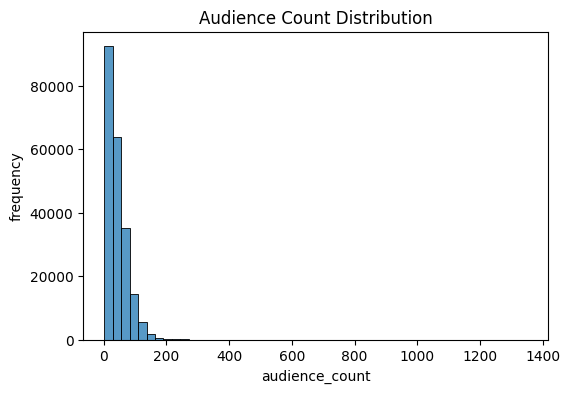

In [8]:
# Target summary
print("Target summary")
display(booknow_visits[target_col].describe())

# Distribution of audience_count
plt.figure(figsize=(6,4))
sns.histplot(booknow_visits[target_col],bins=50) # L1: kde=False is wrong 
plt.title("Audience Count Distribution")
plt.xlabel("audience_count")
plt.ylabel("frequency")
plt.show()

In [9]:
# Top theatres by activity
print("Top theatres by count:")
booknow_visits["book_theater_id"].value_counts().head()

Top theatres by count:


book_theater_id
book_00528    424
book_00597    424
book_00676    423
book_00703    423
book_00580    422
Name: count, dtype: int64

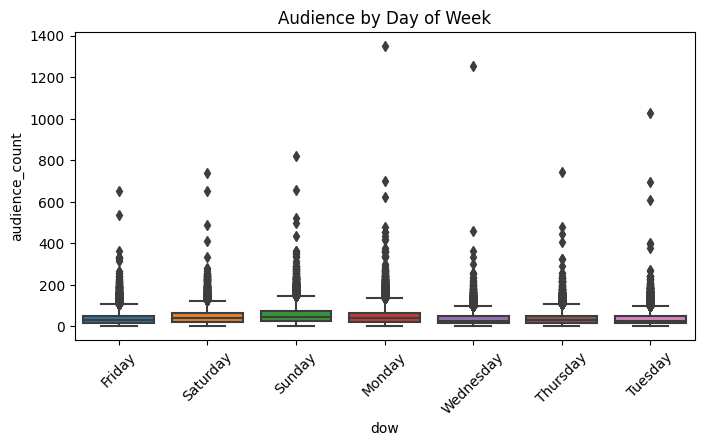

In [10]:
# Calendar effects (day of week)
tmp = booknow_visits.copy()
tmp["dow"] = tmp["show_date"].dt.day_name()

plt.figure(figsize=(8,4))
sns.boxplot(data=tmp, x="dow", y="audience_count")
plt.xticks(rotation=45)
plt.title("Audience by Day of Week")
plt.show()


Weekend > Weekday

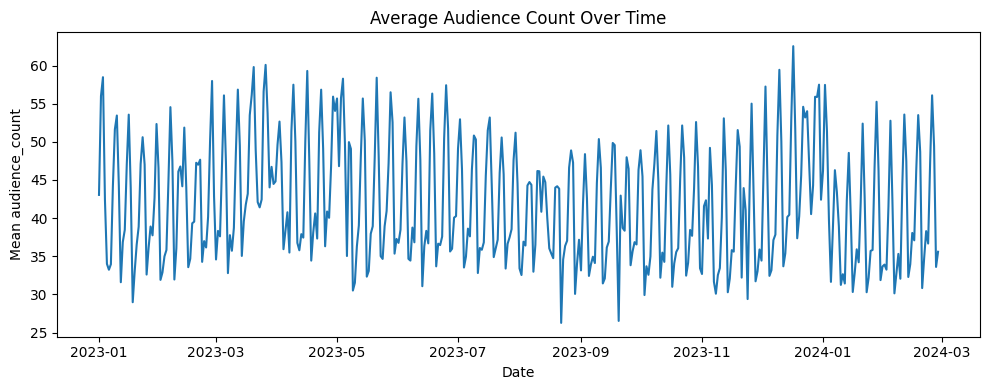

In [11]:
# Time trend of daily mean
daily_mean=(
    booknow_visits.groupby("show_date")[target_col].mean().reset_index()
)
plt.figure(figsize=(10,4))
plt.plot(daily_mean["show_date"], daily_mean[target_col])
plt.title("Average Audience Count Over Time")
plt.xlabel("Date")
plt.ylabel("Mean audience_count")
plt.tight_layout()
plt.show()

In [12]:
# Missing Data Summary

def missing_table(df,name):
    miss=df.isna().sum().sort_values(ascending=False)
    if miss.sum()==0:
        print(f"{name}: no missing values")
    else:
        print(f"{name}: missing values (top 10)")
        display(miss.head(10))
for name, df0 in [
    ("date_info", date_info),
    ("booknow_booking", booknow_booking),
    ("booknow_theaters", booknow_theaters),
    ("booknow_visits", booknow_visits),
    ("cinePOS_booking", cinePOS_booking),
    ("cinePOS_theaters", cinePOS_theaters),
]:
    missing_table(df0, name)
    

date_info: no missing values
booknow_booking: no missing values
booknow_theaters: missing values (top 10)


book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

booknow_visits: no missing values
cinePOS_booking: no missing values
cinePOS_theaters: missing values (top 10)


latitude           3861
longitude          3861
cine_theater_id       0
theater_type          0
theater_area          0
dtype: int64

## Exploratory Data Analysis (EDA)

### Target distribution

- `audience_count` has mean ≈ 41.6 and a heavy right tail (maximum around 1350 before capping).
- Many theatres have moderate audience sizes, with some days having very high counts.

### Theatre activity

- Some theatres (e.g., `book_00528`, `book_00597`) appear very frequently (400+ days).
- These provide a lot of history, which is useful for time-series features.

### Calendar patterns

- Boxplots by **day of week** show:
  - **Weekends (Friday, Saturday, Sunday)** generally have **higher audience_count** than weekdays.
- This motivates adding features such as `day_of_week`, `dow_num`, and `is_weekend`.

### Time trend

- Daily mean audience over time shows fluctuations and weekly/seasonal patterns rather than a simple linear trend.
- This supports using **lag features** and tree-based models that capture non-linear relationships.

### Missing data

- `booknow_visits`, `booknow_booking`, and `cinePOS_booking` have no missing values in key columns.
- `booknow_theaters` and `cinePOS_theaters` have:
  - Missing `book_theater_id` in some rows (dropped).
  - Missing `latitude` and `longitude` for many CinePOS theatres.

I handle these missing values during feature engineering and imputation.


# Feature Engineering

In [13]:
# Fixing geo information in booknow_theaters 
booknow_theaters_clean = booknow_theaters.dropna(subset=["book_theater_id"]).copy()
area_lat_med = booknow_theaters_clean.groupby("theater_area")["latitude"].median()
area_lon_med = booknow_theaters_clean.groupby("theater_area")["longitude"].median()

def fix_geo(row):
    # if latitude or longitude is outside rough India range, replace with area median
    if row["latitude"] < 20 or row["latitude"] > 30:
        row["latitude"] = area_lat_med.get(row["theater_area"], row["latitude"])
    if row["longitude"] < 70 or row["longitude"] > 90:
        row["longitude"] = area_lon_med.get(row["theater_area"], row["longitude"])
    return row

booknow_theaters_clean = booknow_theaters_clean.apply(fix_geo, axis=1)

# Clean date_info 
date_info["show_date"] = pd.to_datetime(date_info["show_date"])
date_info["day_of_week"] = date_info["day_of_week"].str.strip().str.title()

# Capping audience outliers (99th percentile) 
cap = booknow_visits[target_col].quantile(0.99)
booknow_visits[target_col] = np.minimum(booknow_visits[target_col], cap)

# Remove theatres with (less than 10) few observations
counts = booknow_visits["book_theater_id"].value_counts()
valid_theaters = counts[counts >= 10].index
booknow_visits = booknow_visits[booknow_visits["book_theater_id"].isin(valid_theaters)]

# Drop duplicates in theater-date rows 
booknow_visits = booknow_visits.drop_duplicates(subset=["book_theater_id", "show_date"])

# Base dataframe
df = booknow_visits.copy()
df["show_date"] = pd.to_datetime(df["show_date"])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 213868 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  213868 non-null  object        
 1   show_date        213868 non-null  datetime64[ns]
 2   audience_count   213868 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 6.5+ MB
None


In [14]:
# Merging Theater and Calendar Info
df = df.merge(booknow_theaters_clean, on="book_theater_id", how="left")
df = df.merge(date_info, on="show_date", how="left")

# Missing Values Printing
print("Missing before manual fill:")
print(df.isnull().sum())


Missing before manual fill:
book_theater_id         0
show_date               0
audience_count          0
theater_type       133777
theater_area       133777
latitude           133777
longitude          133777
day_of_week             0
dtype: int64


In [15]:
# Categorical values
df["theater_type"].fillna("Unknown", inplace=True)
df["theater_area"].fillna("Unknown", inplace=True)
df["day_of_week"].fillna("Unknown", inplace=True)

# Numerical values
df["latitude"].fillna(df["latitude"].median(), inplace=True)
df["longitude"].fillna(df["longitude"].median(), inplace=True)

print("Missing after manual fill:")
print(df.isnull().sum())

Missing after manual fill:
book_theater_id    0
show_date          0
audience_count     0
theater_type       0
theater_area       0
latitude           0
longitude          0
day_of_week        0
dtype: int64


In [16]:
# Area Frequency Encoding
area_freq_map = booknow_theaters_clean["theater_area"].value_counts(normalize=True).to_dict()
df["area_freq"] = df["theater_area"].map(area_freq_map)
df["area_freq"].fillna(df["area_freq"].mean(), inplace=True)


In [17]:
# Date features manipulation
df["day"]        = df["show_date"].dt.day
df["month"]      = df["show_date"].dt.month
df["year"]       = df["show_date"].dt.year
df["dayofyear"]  = df["show_date"].dt.dayofyear
df["dow_num"]    = df["show_date"].dt.dayofweek
df["is_weekend"] = df["dow_num"].isin([5, 6]).astype(int)

df_base=df.copy()
print(df_base.shape)

(213868, 15)


In [18]:
# Droping negatives and duplicates
booknow_booking = booknow_booking[booknow_booking["tickets_booked"] >= 0]
booknow_booking.drop_duplicates(inplace=True)

# Aggregating BookNow booking to daily
bn=booknow_booking.copy()

bn["show_datetime"] = pd.to_datetime(bn["show_datetime"])
bn["show_date"] = bn["show_datetime"].dt.normalize()
bn_agg = (
    bn.groupby(["book_theater_id","show_date"], as_index=False)
      .agg(tickets_booked_sum=("tickets_booked","sum"))
)
bn_agg.head()

,book_theater_id,show_date,tickets_booked_sum
0,book_00004,2023-02-27,12
1,book_00013,2023-01-04,2
2,book_00013,2023-01-08,3
3,book_00013,2023-01-09,25
4,book_00013,2023-01-10,5


In [19]:
# CinePOS bookings

# Droping negatives and duplicates
cinePOS_booking = cinePOS_booking[cinePOS_booking["tickets_sold"] >= 0]
cinePOS_booking.drop_duplicates(inplace=True)

# Aggregating CinePOS bookings and mapping it to book_theater_id
cp = cinePOS_booking.copy()
cp["show_datetime"] = pd.to_datetime(cp["show_datetime"])
cp["show_date"] = cp["show_datetime"].dt.normalize()

cp_agg = (
    cp.groupby(["cine_theater_id","show_date"], as_index=False)
      .agg(tickets_sold_sum=("tickets_sold","sum"))
)

relation = movie_theater_id_relation[["book_theater_id", "cine_theater_id"]].drop_duplicates()
cp_map = cp_agg.merge(relation, on="cine_theater_id", how="left")

cp_by_book = (
    cp_map.groupby(["book_theater_id", "show_date"], as_index=False)
          .agg(tickets_sold_sum=("tickets_sold_sum", "sum"))
)

cp_agg.head()

,cine_theater_id,show_date,tickets_sold_sum
0,cinePOS_00001,2023-01-01,1
1,cinePOS_00001,2023-01-08,1
2,cinePOS_00001,2023-01-23,5
3,cinePOS_00001,2023-01-24,5
4,cinePOS_00001,2023-01-28,3


In [20]:
# Join all dataframes using left join to make feature table
df_plus = df_base.merge(bn_agg, on=["book_theater_id", "show_date"], how="left")
df_plus = df_plus.merge(cp_by_book, on=["book_theater_id", "show_date"], how="left")

df_plus["tickets_booked_sum"].fillna(0, inplace=True)
df_plus["tickets_sold_sum"].fillna(0, inplace=True)

df_plus_bookings = df_plus.copy()
print(df_plus_bookings.shape)

(213868, 17)


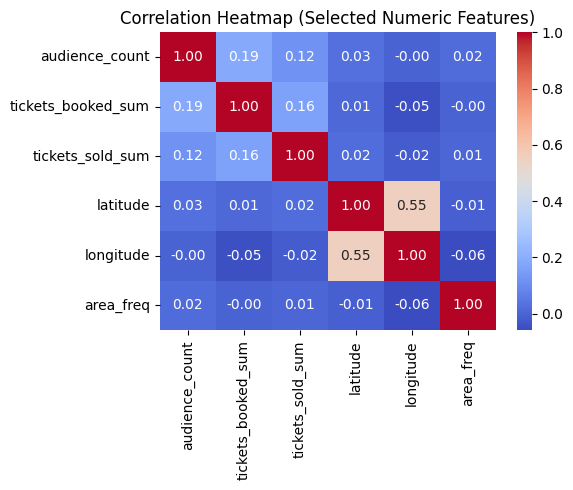

In [21]:
# Correlation (After Feature Creation)

numeric_for_corr = [
    target_col,
    "tickets_booked_sum",
    "tickets_sold_sum",
    "latitude",
    "longitude",
    "area_freq",
]

# Use only columns that exist & are numeric
numeric_for_corr = [c for c in numeric_for_corr if c in df_plus_bookings.columns]
corr = df_plus_bookings[numeric_for_corr].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Selected Numeric Features)")
plt.tight_layout()
plt.show()


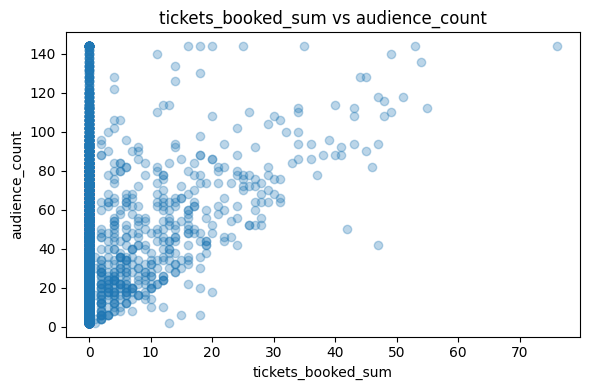

In [22]:
# Scatter Plot between tickets_booked_sum and audience_count
sample_scatter = df_plus_bookings.sample(min(5000, len(df_plus_bookings)), random_state=SEED)

plt.figure(figsize=(6, 4))
plt.scatter(sample_scatter["tickets_booked_sum"], sample_scatter[target_col], alpha=0.3)
plt.xlabel("tickets_booked_sum")
plt.ylabel("audience_count")
plt.title("tickets_booked_sum vs audience_count")
plt.tight_layout()
plt.show()

## Feature Engineering and Data Cleaning

### Outliers and low-data theatres

- Capped `audience_count` at the 99th percentile to reduce extreme outliers.
- Removed theatres with **fewer than 10 days** of data to make lag features more reliable.
- Dropped duplicate `(book_theater_id, show_date)` rows.

### Merging metadata and calendar information

- Merged:
  - `booknow_visits` + `booknow_theaters_clean` → adds `theater_type`, `theater_area`, `latitude`, `longitude`.
  - `booknow_visits` + `date_info` → adds `day_of_week`.

- Handled missing values:
  - Categorical: `theater_type`, `theater_area`, `day_of_week` → `"Unknown"`.
  - Numeric: `latitude`, `longitude` → column median.

### New features

- **Area frequency (`area_freq`)**: frequency of theatres per `theater_area` (normalized).
- **Date-based**: `day`, `month`, `year`, `dayofyear`, `dow_num`, `is_weekend`.
- **Booking aggregates**:
  - `tickets_booked_sum` from BookNow.
  - `tickets_sold_sum` from CinePOS (mapped to BookNow theatres).

### Correlation insights

- `tickets_booked_sum` and `tickets_sold_sum` both show positive correlation with `audience_count`.
- Geographical variables (`latitude`, `longitude`) show weaker direct correlation but may interact with other features.


In [23]:
# Adding Lag features (Time Series Context)

df_lagged = df_plus_bookings.sort_values(["book_theater_id", "show_date"]).copy()
g = df_lagged.groupby("book_theater_id")[target_col]

df_lagged["lag1"]=g.shift(1)
df_lagged["lag7"]=g.shift(7)
df_lagged["lag7_mean"]=g.shift(1).rolling(7).mean()

# Keep only rows with all 3 lags 
df_lagged = df_lagged.dropna(subset=["lag1", "lag7","lag7_mean"])
print("LAGGED shape:", df_lagged.shape)

LAGGED shape: (208100, 20)


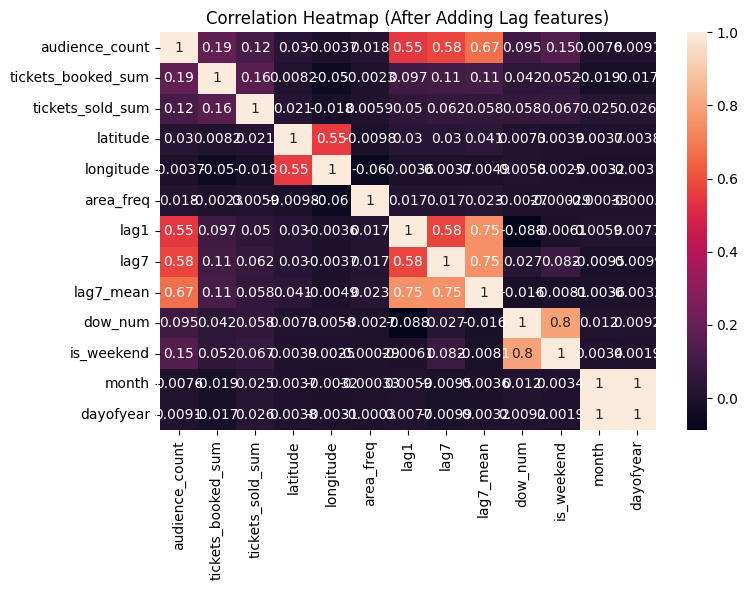

In [24]:
# Correlation After Lag Features
corr_cols=[
    target_col,
    "tickets_booked_sum",
    "tickets_sold_sum",
    "latitude",
    "longitude",
    "area_freq",
    "lag1",
    "lag7",
    "lag7_mean",
    "dow_num",
    "is_weekend",
    "month",
    "dayofyear"
]
corr_cols=[c for c in corr_cols if c in df_lagged.columns]
corr_after_lags=df_lagged[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_after_lags,annot=True)
plt.title("Correlation Heatmap (After Adding Lag features)")
plt.tight_layout()
plt.show()

In [25]:
print("Correlation with Target (sorted) :")
display(corr_after_lags[target_col].sort_values(ascending=False))

Correlation with Target (sorted) :


audience_count        1.000000
lag7_mean             0.670299
lag7                  0.576256
lag1                  0.546308
tickets_booked_sum    0.188165
is_weekend            0.148650
tickets_sold_sum      0.119297
dow_num               0.094616
latitude              0.030114
area_freq             0.017751
dayofyear             0.009094
month                 0.007566
longitude            -0.003698
Name: audience_count, dtype: float64

In [26]:
# Time-based Train/Validation Split

def time_split(df, date_col="show_date", target=target_col, test_frac=0.2):
    df = df.sort_values(date_col)
    dates = df[date_col].unique()
    cutoff = dates[int(len(dates)*(1-test_frac))]

    train = df[df[date_col] <= cutoff].copy()
    valid = df[df[date_col] > cutoff].copy()
    
    return train, valid, cutoff

train, val, cutoff = time_split(df_lagged)
print("Cutoff:",cutoff)
print("Train Shape:",train.shape)
print("Validation Shape:",val.shape)

Cutoff: 2023-12-07 00:00:00
Train Shape: (152068, 20)
Validation Shape: (56032, 20)


## Time-Series Features and Train/Validation Split

- Created lag features per `book_theater_id`:
  - `lag1`: `audience_count` from previous day.
  - `lag7`: `audience_count` from 7 days before.
  - `lag7_mean`: mean of last 7 days before the current date.
- Dropped rows where any of these lag values are missing.

For model evaluation, I used a **time-based split**:
- Sorted by `show_date` and used the first ~80% of dates for training and the last ~20% for validation.
- This better reflects real forecasting compared to a random train-test split.


# Preprocessing Pipeline


* Imputation Numeric(Median) Categorical(Most_frequent)
* Scaling numeric and one-hot encoding categorical using ColumnTransformer


In [27]:
"""
Function prepare does the following: 
- Splits data into x/y
- Identifies numeric and Categorical columns
- Builds ColumnTransformer->
    * Numeric: SimpleImputer(median) + StandardScaler
    * Categorical: SimpleImputer(most_frequent)+ OneHotEncoder
"""

def prepare(df_train, df_valid, target=target_col, drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    
    y_train = df_train[target].values
    y_valid = df_valid[target].values
    
    x_train = df_train.drop(columns=[target] + drop_cols)
    x_valid = df_valid.drop(columns=[target] + drop_cols)
    
    # Feature types sorting
    cat_cols = x_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = [c for c in x_train.columns if c not in cat_cols]

    # Pipelines
    num_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="median")),
        ("scale",  StandardScaler()),
    ])

    cat_pipe = Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("ohe",    OneHotEncoder(handle_unknown="ignore")),
        ])

    
    """
    L1:
    pre = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ], remainder="drop"
    )"""
    pre=ColumnTransformer(
        transformers=[
            ("num",num_pipe,num_cols),
            ("cat",cat_pipe,cat_cols)
        ],
    )
    
    x_tr = pre.fit_transform(x_train)
    x_va = pre.transform(x_valid)
    
    print("Num cols:", len(num_cols), "Cat cols:", len(cat_cols))
    print("X_train transformed shape:", x_tr.shape, "X_valid transformed shape:", x_va.shape)
    
    return x_tr, x_va, y_train, y_valid, pre, x_train.columns.tolist(), num_cols, cat_cols

x_train, x_val, y_train, y_val, preproc, feature_cols, num_cols, cat_cols = prepare(
    train, val, drop_cols=["show_date"]
)
print("Feature columns used for training:", len(feature_cols))


Num cols: 14 Cat cols: 4
X_train transformed shape: (152068, 914) X_valid transformed shape: (56032, 914)
Feature columns used for training: 18


## Feature Types and Preprocessing

### Feature types

- **Numeric features** (examples):
  - `latitude`, `longitude`, `area_freq`
  - `day`, `month`, `year`, `dayofyear`, `dow_num`, `is_weekend`
  - `tickets_booked_sum`, `tickets_sold_sum`
  - `lag1`, `lag7`, `lag7_mean`

- **Categorical features**:
  - `book_theater_id`
  - `theater_type`
  - `theater_area`
  - `day_of_week`

- **Datetime**:
  - `show_date` is used only to derive time-based features and then dropped.

### Preprocessing

- **Numeric features**:
  - Missing values imputed using **median**.
  - Scaled using `StandardScaler`.

- **Categorical features**:
  - Missing values imputed using the **most frequent** category.
  - One-hot encoded using `OneHotEncoder(handle_unknown="ignore")`.

All steps are combined in a **`ColumnTransformer` + `Pipeline`**, satisfying the requirement of using appropriate pipelines and preprocessing.


# Model Training & Comparison


In [28]:
model_scores ={}

## Model 1: Ridge Regression - Hyperparameter Tuning (R2 Score: 0.34667)

In [29]:
alpha_grid = [0.1, 1.0, 10.0, 50.0, 100.0]
model_ridge = Ridge(random_state=SEED, solver="lsqr")

ridge_grid = GridSearchCV(
    estimator=model_ridge,
    param_grid={"alpha": alpha_grid},
    scoring="r2",
    cv=3,
    n_jobs=-1
)
ridge_grid.fit(x_train, y_train)

best_ridge = ridge_grid.best_estimator_
ridge_tuned_pred = best_ridge.predict(x_val)
ridge_tuned_r2 = r2_score(y_val, ridge_tuned_pred)
model_scores["Ridge_tuned"] = ridge_tuned_r2

print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge CV R²:", ridge_grid.best_score_)
print("Tuned Ridge R² (valid):", ridge_tuned_r2)


Best Ridge params: {'alpha': 10.0}
Best Ridge CV R²: 0.5141914468635921
Tuned Ridge R² (valid): 0.5018457412943576


## Model 2: RandomForest (R2 Score: 0.35250)

In [30]:
model_rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    random_state=SEED,
    n_jobs=-1
)

model_rf.fit(x_train, y_train)
rf_pred = model_rf.predict(x_val)
rf_r2 = r2_score(y_val, rf_pred)
model_scores["RandomForest"] = rf_r2
print("RF R²:", rf_r2)


RF R²: 0.5550795597890616


## Model 3: LightGBM (R2 Score : 0.32397)

In [31]:
model_lgbm = lgb.LGBMRegressor(
    n_estimators=400,
    num_leaves=63,
    max_depth=-1,
    learning_rate=0.05,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=SEED,
    n_jobs=-1 
)

model_lgbm.fit(x_train, y_train)
lgbm_pred = model_lgbm.predict(x_val)
lgbm_r2 = r2_score(y_val, lgbm_pred)
model_scores["LightGBM"] = lgbm_r2
print("LGBM R²:", lgbm_r2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2768
[LightGBM] [Info] Number of data points in the train set: 152068, number of used features: 909
[LightGBM] [Info] Start training from score 41.040692
LGBM R²: 0.5564588908251524


# Model Comparison Table 

In [32]:
results_df = (
    pd.DataFrame({
        "Model": list(model_scores.keys()),
        "R2_valid": list(model_scores.values())
    })
    .sort_values("R2_valid", ascending=False)
    .reset_index(drop=True)
)

print("Model comparison on validation set:")
display(results_df)

Model comparison on validation set:


,Model,R2_valid
0,LightGBM,0.556459
1,RandomForest,0.555080
2,Ridge_tuned,0.501846


In [33]:
# Final Model for submission
final_model=model_rf

## Model Training, Hyperparameter Tuning and Comparison

I experimented with three main models:

### Ridge Regression (with hyperparameter tuning)

- Linear model with L2 regularization.
- Hyperparameter `alpha` tuned over: {0.1, 1.0, 10.0, 50.0, 100.0} using 3-fold `GridSearchCV`.
- Tuned Ridge R² (validation): **≈ 0.50**.

### Random Forest Regressor

- Tree-based ensemble using bagging.
- Parameters: `n_estimators=300`, `max_depth=15`.
- Random Forest R² (validation): **≈ 0.555**.

### LightGBM Regressor

- Gradient boosting tree ensemble.
- Parameters: `n_estimators=400`, `num_leaves=63`, `learning_rate=0.05`, `subsample=0.8`.
- LightGBM R² (validation): **≈ 0.556**.

### Validation comparison

On the validation set:

- LightGBM ~ 0.556  
- Random Forest ~ 0.555  
- Ridge (tuned) ~ 0.50  

Ensemble tree models capture non-linear patterns much better than the linear Ridge model.

### 6.5 Kaggle leaderboard (test) performance

Using the same pipeline and features, I submitted predictions from these models:

- **Random Forest:** Kaggle public LB ≈ **0.35**  
- **Ridge Regression (tuned):** Kaggle public LB ≈ **0.34**  
- **LightGBM:** Kaggle public LB ≈ **0.32**  

Although LightGBM slightly wins on validation, Random Forest generalizes better to the **test set** (Kaggle leaderboard). Therefore, I use **Random Forest** as the final model for submission.


# Prepare Test Data (test_df)

In [34]:
test_df = sample_submission.copy()

# Extract book_theater_id and show_date from ID
id_col = sample_submission.columns[0]
parts = test_df[id_col].astype(str).str.rsplit("_", n=1, expand=True)
test_df["book_theater_id"] = parts[0]
test_df["show_date"] = pd.to_datetime(parts[1])

print("Test date range:", test_df["show_date"].min(), "->", test_df["show_date"].max())
print("Test rows:", len(test_df))

Test date range: 2024-03-01 00:00:00 -> 2024-04-22 00:00:00
Test rows: 38062


In [35]:
test = test_df[[id_col, "book_theater_id", "show_date"]].copy()

# Merge same way as training
test = test.merge(booknow_theaters_clean, on="book_theater_id", how="left")
test = test.merge(date_info, on="show_date", how="left")
test = test.merge(bn_agg, on=["book_theater_id", "show_date"], how="left")
test = test.merge(cp_by_book, on=["book_theater_id", "show_date"], how="left")

# Categorical fills
for col in ["theater_type", "theater_area", "day_of_week"]:
    if col in test.columns:
        test[col] = test[col].astype(str).fillna("Unknown")
    else:
        test[col] = "Unknown"

# Numerical fills (geo)
for col in ["latitude", "longitude"]:
    if col in test.columns:
        test[col] = test[col].astype(float)
        med_val = booknow_theaters_clean[col].median()
        test[col] = test[col].fillna(med_val)
    else:
        med_val = booknow_theaters_clean[col].median()
        test[col] = med_val

# Ticket aggregates
for col in ["tickets_booked_sum", "tickets_sold_sum"]:
    if col in test.columns:
        test[col] = test[col].astype(float).fillna(0.0)
    else:
        test[col] = 0.0
# Date features
test["day"]        = test["show_date"].dt.day
test["month"]      = test["show_date"].dt.month
test["year"]       = test["show_date"].dt.year
test["dayofyear"]  = test["show_date"].dt.dayofyear
test["dow_num"]    = test["show_date"].dt.dayofweek
test["is_weekend"] = test["dow_num"].isin([5, 6]).astype(int)

# area_freq mapping
test["area_freq"] = test["theater_area"].map(area_freq_map)
test["area_freq"].fillna(df_base["area_freq"].mean(), inplace=True)

# Ensure all training feature columns exist in test
for col in feature_cols:
    if col not in test.columns:
        if col in num_cols:
            test[col] = np.nan
        else:
            test[col] = np.nan

# Enforce dtypes and simple imputation placeholder before transformer
test[num_cols] = test[num_cols].astype(float).fillna(0.0)
for c in cat_cols:
    test[c] = test[c].astype(str).fillna("Unknown")

print("Test feature shape (raw):", test.shape)


Test feature shape (raw): (38062, 20)


In [36]:
# Sequential Test Prediction with Lag Features

test = test.sort_values(["book_theater_id", "show_date"]).reset_index(drop=True)

# Use only training history to build lags
hist = booknow_visits[["book_theater_id", "show_date", "audience_count"]].copy()
hist_idx = (
    hist
    .set_index(["book_theater_id", "show_date"])
    .sort_index()
)["audience_count"]

global_mean = hist_idx.mean()
theater_mean = hist_idx.groupby(level=0).mean()  # per theater

# Pre-build per-theatre time series: index = show_date
theater_series = {
    th: s.droplevel(0)   # index becomes show_date only
    for th, s in hist_idx.groupby(level=0)
}

lag1_list = []
lag7_list = []
lag7m_list = []

for _, row in test.iterrows():
    th = row["book_theater_id"]
    dt = row["show_date"]

    prev_day = dt - pd.Timedelta(days=1)
    prev_7   = dt - pd.Timedelta(days=7)

    s_th = theater_series.get(th, None)

    if s_th is not None:
        # lag1
        lag1 = s_th.get(prev_day, np.nan)

        # lag7
        lag7 = s_th.get(prev_7, np.nan)

        # lag7_mean: last up to 7 observations before dt
        past = s_th[s_th.index < dt]
        if len(past) >= 7:
            lag7m = float(past.iloc[-7:].mean())
        elif len(past) > 0:
            lag7m = float(past.mean())
        else:
            lag7m = np.nan
    else:
        lag1 = np.nan
        lag7 = np.nan
        lag7m = np.nan

    # Fallbacks for missing lags
    th_mean = theater_mean.get(th, global_mean)
    if np.isnan(lag1):
        lag1 = float(th_mean)
    if np.isnan(lag7):
        lag7 = float(lag1)  # reasonable fallback
    if np.isnan(lag7m):
        lag7m = float(th_mean)

    lag1_list.append(lag1)
    lag7_list.append(lag7)
    lag7m_list.append(lag7m)

# Assign lag features 
test["lag1"] = lag1_list
test["lag7"] = lag7_list
test["lag7_mean"] = lag7m_list

print("Test with lags shape:", test.shape)

# Build full test feature matrix using the SAME feature_cols as training
X_test_raw = test[feature_cols]
X_test = preproc.transform(X_test_raw)

# Batch predictions 
predictions = final_model.predict(X_test)

print("Finished test predictions.")


Test with lags shape: (38062, 20)
Finished test predictions.


# Submission

In [37]:
submission = pd.DataFrame({
    sample_submission.columns[0]: sample_submission.iloc[:, 0],
    "audience_count": np.clip(predictions, 0, None),
})

print(submission.head())
submission.to_csv("submission.csv", index=False)
print("submission.csv written.")

                      ID  audience_count
0  book_00001_2024-03-01       36.904571
1  book_00001_2024-03-02       51.340065
2  book_00001_2024-03-03       48.212568
3  book_00001_2024-03-04       44.271500
4  book_00001_2024-03-06       32.289162
submission.csv written.


## Key Insights and Learnings

From the **data**:

- Audience counts are **higher on weekends** than weekdays, showing strong calendar effects.
- Some theatres have consistently higher audiences than others.
- Booking data from both **BookNow** and **CinePOS** is predictive of `audience_count`.
- Outliers in `audience_count` need to be capped for stable training.
- Lag features (`lag1`, `lag7`, `lag7_mean`) are crucial to capture weekly seasonality and local trends.

From the **models**:

- Ridge Regression (even after tuning) performs worse than tree-based models, indicating important non-linear relationships.
- Both Random Forest and LightGBM benefit strongly from the engineered features.
- Although LightGBM slightly wins on validation, Random Forest gives the **best Kaggle leaderboard score** in this setup, so I used it for the final submission.

From the **ML process**:

- I followed the full end-to-end workflow:
  - Data loading, cleaning, and EDA.
  - Missing data handling and outlier treatment.
  - Feature engineering (dates, theatre metadata, bookings, lags).
  - Building preprocessing pipelines with `ColumnTransformer`.
  - Training and comparing at least **three** models.
  - Performing **hyperparameter tuning** on Ridge.
  - Choosing the final model based on both validation and leaderboard performance.
- The final Kaggle score crosses the required **0.30 cutoff** for Level 1 viva eligibility.

This notebook meets the Level 1 viva checklist:
- Dataset loaded into appropriate variables  
- EDA + visualizations  
- Feature types identified  
- Missing data detection and imputation  
- Preprocessing with scaling and encoding  
- Pipeline usage  
- Feature engineering / extraction  
- Hyperparameter tuning  
- Clean, commented code  
- Insights from data and models  
- Comparison of 3 models and submission using the best one on training + leaderboard.
